In [106]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
%matplotlib widget

### Constante

In [107]:
ua = 149597870700 # m/ua
d = 86400 # s/d
m_sun = 1.9885e30 # kg/m_Sun
G = 6.67430e-11 # m³/kg/s² 
G = G*(86400**2)*m_sun/(ua**3) # ua³/m_Sun/d²
masses2 = np.array([1.9885e30, 1.898e27])/1.9885e30 # [Sun, Jupiter] in m_Sun
masses = np.array([1.9885e30, 1.898e27, 5,6846e26])/1.9885e30


### Repères
Nomenclature : coord_astre1_astre2 = coordonnées de l'astre 1 par rapport à l'astre 2

Je vais travailler par rapport au Soleil en (0,0,0) et plus le CM


In [108]:
# Changement de repères et d'unités d'angles
hms_to_rad = lambda x: 2*np.pi/24* (x[0]+x[1]/60+x[2]/3600)
dms_to_rad = lambda x: 2*np.pi/360*(x[0]+x[1]/60+x[2]/3600)
coord_2D = lambda r,phi,theta: np.array([r*np.cos(phi),r*np.sin(phi),0.])
coord_3D = lambda r,phi,theta: np.array([r*np.cos(phi)*np.sin(theta),r*np.sin(phi)*np.sin(theta),r*np.cos(theta)])
def str_to_list(t):
    lst = str.split(t,' ')
    for i in range(len(lst)):
        lst[i] = float(lst[i])
    return lst

def Spher_To_Cart(N,masses,r, RA_hms, DEC_dms, center='Sun',dim='2D'):
    """
    === Params ===\n
    r:      2D array (N,2) of distance wrt the Sun
            First axis : body (0 -> Sun, 1 -> Jup, ...)
            Second axis : 0 = data at t1, 1 = data at t2
    RA_hms: 2D array (N-1,2,3) of Right angle wrt the Sun
            First axis : body (0 -> Jup, 1 -> Sat, ...)
            Second axis : 0 = data at t1, 1 = data at t2
            Third axis : [hour, min, sec]
    DEC_dms:2D array (N-1,2,3) Declination wrt the Sun
            First axis : body (0 -> Jup, 1 -> Sat, ...)
            Second axis : 0 = data at t1, 1 = data at t2
            Third axis : [degree, min, sec]
    center: 'Sun' or 'CM' 
            Center of the cartesian frame
    dim:    '2D' or '3D' 
            Dimension of output frame
    === Return ===\n
    coord : 2D array (N,3) of cartesian coordinates wrt to center
    vit :   2D array (N,3) of velocity wrt to center
    """
    coord = np.zeros((N,3))
    coord2 = np.zeros((N,3))
    vit = np.zeros((N,3))
    r.insert(0,[0,0])
    RA_hms.insert(0,[[0,0,0],[0,0,0]])
    DEC_dms.insert(0,[[0,0,0],[0,0,0]])
    RA_rad = np.zeros((N,2))
    DEC_rad = np.zeros((N,2))
    # RA_rad2 = np.zeros(N)
    # DEC_rad2 = np.zeros(N)
    for i in range(1,N):
        RA_rad[i] = hms_to_rad(RA_hms[i][0]),hms_to_rad(RA_hms[i][1])
        # RA_rad2[i] = hms_to_rad(RA_hms[i][1])
        DEC_rad[i] = np.pi/2-dms_to_rad(DEC_dms[i][0]),np.pi/2-dms_to_rad(DEC_dms[i][1])
        # DEC_rad2[i] = dms_to_rad(DEC_dms[i][1])
        if dim=='2D':
             coord[i] = coord_2D(r[i][0],RA_rad[i][0],DEC_rad[i][0])
             coord2[i] = coord_2D(r[i][1],RA_rad[i][1],DEC_rad[i][1])
        elif dim=='3D':
             coord[i] = coord_3D(r[i][0],RA_rad[i][0],DEC_rad[i][0])
             coord2[i] = coord_3D(r[i][1],RA_rad[i][1],DEC_rad[i][1])
    
    R1 = masses[1]*coord[1]/(masses[0]+masses[1])
    R2 = masses[1]*coord2[1]/(masses[0]+masses[1])
    for i in range(N):
        if center == 'CM':
            coord[i] = coord[i]-R1
            coord2[i] = coord2[i]-R2
        vit[i] = (coord2[i]-coord[i])*86400

    return coord, vit
"""
# # Calcul position 1
# RA_hms1 = [3,38,37.78488]
# DEC_dms1 = [18,32,57.7628]
# RA_rad1 = hms_to_rad(RA_hms1)
# DEC_rad1 = np.pi/2-dms_to_rad(DEC_dms1)
# r1 = 5.012361271
# # Coordinates wrt the Sun
# coord_Sun_Sun1 = np.zeros(3)
# coord_Jup_Sun1 = coord_2D(r1,RA_rad1,DEC_rad1)
# # Coordinates wrt the CM
# R1 = masses[1]*coord_Jup_Sun1/(masses[0]+masses[1])
# coord_Jup_CM1 = coord_Jup_Sun1-R1
# coord_Sun_CM1 = coord_Sun_Sun1-R1

# # Calcul position 2
# RA_hms2 = [3,38,37.78513]
# DEC_dms2 = [18,32,57.7637]
# RA_rad2 = hms_to_rad(RA_hms2)
# DEC_rad2 = np.pi/2-dms_to_rad(DEC_dms2)
# r2 = 5.012361274
# # Coordinates wrt the Sun
# coord_Sun_Sun2 = coord_Sun_Sun1
# coord_Jup_Sun2 = coord_2D(r2,RA_rad2,DEC_rad2)
# # Coordinates wrt the CM
# R2 = masses[1]*coord_Jup_Sun2/(masses[0]+masses[1])
# coord_Jup_CM2 = coord_Jup_Sun2-R2
# coord_Sun_CM2 = coord_Sun_Sun2-R2

# # Calcul vitesse (approx linéaire aval)
# # Par rapport au Sun
# vit_Sun_Sun = np.array([0.,0.,0.]) 
# vit_Jup_Sun = (coord_Jup_Sun2-coord_Jup_Sun1)*86400
# # Par rapport au CM
# vit_Sun_CM = (coord_Sun_CM2-coord_Sun_CM1)*86400
# vit_Jup_CM = (coord_Jup_CM2-coord_Jup_CM1)*86400

# print(coord_Sun_Sun1)
# print(coord_Jup_Sun1)
# # print(coord_Sat_Sun1)
# print(vit_Sun_CM)
# print(vit_Jup_CM)
# # print(vit_Sat)
"""

'\n# # Calcul position 1\n# RA_hms1 = [3,38,37.78488]\n# DEC_dms1 = [18,32,57.7628]\n# RA_rad1 = hms_to_rad(RA_hms1)\n# DEC_rad1 = np.pi/2-dms_to_rad(DEC_dms1)\n# r1 = 5.012361271\n# # Coordinates wrt the Sun\n# coord_Sun_Sun1 = np.zeros(3)\n# coord_Jup_Sun1 = coord_2D(r1,RA_rad1,DEC_rad1)\n# # Coordinates wrt the CM\n# R1 = masses[1]*coord_Jup_Sun1/(masses[0]+masses[1])\n# coord_Jup_CM1 = coord_Jup_Sun1-R1\n# coord_Sun_CM1 = coord_Sun_Sun1-R1\n\n# # Calcul position 2\n# RA_hms2 = [3,38,37.78513]\n# DEC_dms2 = [18,32,57.7637]\n# RA_rad2 = hms_to_rad(RA_hms2)\n# DEC_rad2 = np.pi/2-dms_to_rad(DEC_dms2)\n# r2 = 5.012361274\n# # Coordinates wrt the Sun\n# coord_Sun_Sun2 = coord_Sun_Sun1\n# coord_Jup_Sun2 = coord_2D(r2,RA_rad2,DEC_rad2)\n# # Coordinates wrt the CM\n# R2 = masses[1]*coord_Jup_Sun2/(masses[0]+masses[1])\n# coord_Jup_CM2 = coord_Jup_Sun2-R2\n# coord_Sun_CM2 = coord_Sun_Sun2-R2\n\n# # Calcul vitesse (approx linéaire aval)\n# # Par rapport au Sun\n# vit_Sun_Sun = np.array([0.,0.

### Méthode

In [109]:
def Init_Cond(N,masses, r, RA_hms, DEC_dms, **kwargs):
    """
    === Params ===\n
    N :         Number of Body
    r :         2D array (N,2) of distance wrt the Sun
                First axis : body (0 -> Sun, 1 -> Jup, ...)
                Second axis : 0 = data at t1, 1 = data at t2
    RA_hms :    2D array (N-1,2,3) of Right angle wrt the Sun
                First axis : body (0 -> Jup, 1 -> Sat, ...)
                Second axis : 0 = data at t1, 1 = data at t2
                Third axis : [hour, min, sec]
    DEC_dms :   2D array (N-1,2,3) Declination wrt the Sun
                First axis : body (0 -> Jup, 1 -> Sat, ...)
                Second axis : 0 = data at t1, 1 = data at t2
                Third axis : [degree, min, sec]
    **kawrgs :  argument center and dim from Spher_to_Cart(func)
    === Return ===\n
    pos_init :  1D array of positions [x_Sun, y_Sun, z_Sun, x_Jup, ...]
    vit_init :  1D array of momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
    """
    pos_init = np.zeros(N*3)
    mom_init = np.zeros(N*3)
    pos, vit = Spher_To_Cart(N,masses,r,RA_hms,DEC_dms,**kwargs)
    for i in range(N):
        pos_init[i*3] = pos[i][0]
        pos_init[i*3+1] = pos[i][1]
        pos_init[i*3+2] = pos[i][2]

        mom_init[i*3] = vit[i][0]*masses[i]
        mom_init[i*3+1] = vit[i][1]*masses[i]
        mom_init[i*3+2] = vit[i][2]*masses[i]
    return pos_init, mom_init

def distance(x1,x2):
    return (np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2+(x1[2]-x2[2])**2))

def dpos_dt(pos,mom,masses):
    N = len(masses)
    dpos = np.zeros_like(pos)
    for i in range(N):
        j = i*3
        dpos[j:j+3] = mom[j:j+3]/masses[i]
    return dpos

def dmom_dt(pos,mom,masses):
    N = len(masses)
    dmom = np.zeros_like(mom)
    for i in range(N):
        j = i*3
        for k in range(N):
            l = k*3
            if i!=k :
                dmom[j:j+3] += -G*masses[i]*masses[k]/(distance(pos[j:j+3],pos[l:l+3])**3)*(pos[j:j+3]-pos[k:k+3])
    return dmom

def energy(pos,mom,masses):
    N = len(masses)
    kin = 0
    pot = 0
    for i in range(N):
        j = i*3
        kin += 1/2*np.dot(mom[j:j+3],mom[j:j+3])/masses[i]
        for k in range(i+1,N):
            l = k*3
            pot += G*masses[i]*masses[k]/(distance(pos[j:j+3],pos[l:l+3])**2)
    return kin-pot


In [110]:
def Eula(masses, pos_init, mom_init, dt, tmax):
    """
    === Params ===\n
    masses :    array of masses [Sun, Jupiter]
    pos_init :  2D array of position
                First axis : coordinates [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep            
    mom_init :    2D array of momentum
                First axis : momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep
    === Return ===\n
    dict :      't' :   1D array of timestep
                'pos' : 2D array of positions
                        First index : coordinates
                        Second index : timestep
                'mom' : 2D array of momentum
                        First index : coordinate
                        Second index : timestep
                'E' :   1D array of energy through time
    """
    t = np.arange(0,tmax+dt,dt)
    N = int(len(pos_init)/3)
    masses = masses[:N]
    pos = np.zeros((len(pos_init),len(t)))
    mom = np.zeros((len(mom_init),len(t)))
    E = np.zeros(len(t))
    pos[:,0] = pos_init
    mom[:,0] = mom_init
    E[0] = energy(pos[:,0], mom[:,0],masses)
    for i in range(len(t)-1):
        mom[:,i+1] = mom[:,i] + dt*dmom_dt(pos[:,i],mom[:,i],masses)
        pos[:,i+1] = pos[:,i] + dt*dpos_dt(pos[:,i],mom[:,i],masses)
        E[i+1] = energy(pos[:,i+1], mom[:,i+1],masses) 
    return {'t':t, 'pos':pos, 'mom': mom, 'E':E}

In [111]:
def Heun(masses, pos_init, mom_init, dt, tmax):
    """
    === Params ===\n
    masses :    array of masses [Sun, Jupiter]
    pos_init :  2D array of position
                First axis : coordinates [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep            
    mom_init :    2D array of momentum
                First axis : momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep
    === Return ===\n
    dict :      't' :   1D array of timestep
                'pos' : 2D array of positions
                        First index : coordinates
                        Second index : timestep
                'mom' : 2D array of momentum
                        First index : coordinate
                        Second index : timestep
                'E' :   1D array of energy through time
    """
    t = np.arange(0,tmax+dt,dt)
    N = int(len(pos_init)/3)
    masses = masses[:N]
    pos = np.zeros((len(pos_init),len(t)))
    mom = np.zeros((len(mom_init),len(t)))
    E = np.zeros(len(t))
    pos[:,0] = pos_init
    mom[:,0] = mom_init
    E[0] = energy(pos[:,0], mom[:,0],masses)
    for i in range(len(t)-1):
        mom_tilde = mom[:,i] + dt*dmom_dt(pos[:,i],mom[:,i],masses)
        pos_tilde = pos[:,i] + dt*dpos_dt(pos[:,i],mom[:,i],masses)

        mom[:,i+1] = mom[:,i] + dt/2*(dmom_dt(pos_tilde,mom_tilde,masses)+dmom_dt(pos[:,i],mom[:,i],masses))
        pos[:,i+1] = pos[:,i] + dt/2*(dpos_dt(pos_tilde,mom_tilde,masses)+dpos_dt(pos[:,i],mom[:,i],masses))
        
        E[i+1] = energy(pos[:,i+1], mom[:,i+1], masses)
    return {'t':t,'pos':pos,'mom':mom,'E':E}

In [112]:
def SV(masses, pos_init, mom_init, dt, tmax):
    """
    === Params ===\n
    masses :    array of masses [Sun, Jupiter]
    pos_init :  2D array of position
                First axis : coordinates [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep            
    mom_init :    2D array of momentum
                First axis : momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep
    === Return ===\n
    dict :      't' :   1D array of timestep
                'pos' : 2D array of positions
                        First index : coordinates
                        Second index : timestep
                'mom' : 2D array of momentum
                        First index : coordinate
                        Second index : timestep
                'E' :   1D array of energy through time
    """
    t = np.arange(0,tmax+dt,dt)
    N = int(len(pos_init)/3)
    masses = masses[:N]
    pos = np.zeros((len(pos_init),len(t)))
    mom = np.zeros((len(mom_init),len(t)))
    E = np.zeros(len(t))
    pos[:,0] = pos_init
    mom[:,0] = mom_init
    E[0] = energy(pos[:,0],mom[:,0],masses)
    for i in range(len(t)-1):
        mmom = mom[:,i] + dt/2*dmom_dt(pos[:,i],mom[:,i],masses)
        pos[:,i+1] = pos[:,i] + dt*dpos_dt(pos[:,i],mmom,masses)
        mom[:,i+1] = mmom + dt/2*dmom_dt(pos[:,i+1],mmom,masses)

        E[i+1] = energy(pos[:,i+1],mom[:,i+1],masses)
    return {'t':t,'pos':pos,'mom':mom,'E':E}

### Calculs

In [145]:
# Conditions initiales
r_Jup = [5.012753755,5.012753758]
RA_Jup = [str_to_list('3 39 12.52523'),
          str_to_list('3 39 12.52549')]
DEC_Jup = [str_to_list('18 35 2.9682'),
           str_to_list('18 35 2.9691')]
r_Sat = [9.701550337,9.701550334]
RA_Sat = [str_to_list('22 55 4.66172'),
          str_to_list('22 55 4.66181')]
DEC_Sat = [str_to_list('-08 54 38.4322'),
           str_to_list('-08 54 38.4317')]

pos_init,mom_init = Init_Cond(3,masses,[r_Jup,r_Sat],[RA_Jup,RA_Sat],[DEC_Jup,DEC_Sat],dim='3D')
# pos_init,mom_init = Init_Cond(masses,[coord_Sun_CM1, coord_Jup_CM1],[vit_Sun_CM,vit_Jup_CM])


dt = 1 # nbre de jours par dt
N_tmax = 500 # nbre d'années de la simu
tmax = N_tmax*365 #jours

solEul = Eula(masses, pos_init, mom_init, dt, tmax)
solHeun = Heun(masses, pos_init, mom_init, dt, tmax)
solSV = SV(masses, pos_init, mom_init, dt, tmax)

np.savetxt(fname="./Data/Sun_v.txt", X=solHeun['mom'][0:3,:],delimiter=',')
np.savetxt(fname="./Data/Sun_p.txt", X=solHeun['pos'][0:3,:],delimiter=',')
np.savetxt(fname="./Data/Jup_v.txt", X=solHeun['mom'][3:6,:],delimiter=',')
np.savetxt(fname="./Data/Jup_p.txt", X=solHeun['pos'][3:6,:],delimiter=',')
np.savetxt(fname="./Data/Sat_v.txt", X=solHeun['mom'][6:9,:],delimiter=',')
np.savetxt(fname="./Data/Sat_p.txt", X=solHeun['pos'][6:9,:],delimiter=',')


### Plot Euler

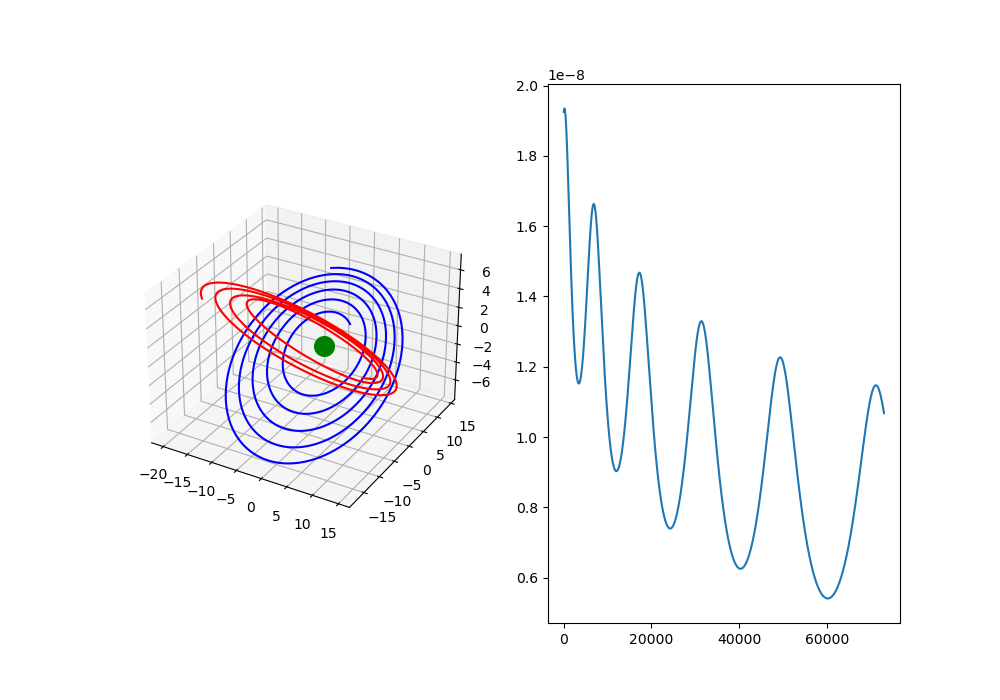

In [121]:
fig= plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.scatter(0,0,0,c='green',s=200)
ax1.plot(solEul['pos'][3,:],solEul['pos'][4,:],solEul['pos'][5,:],c='blue')
ax1.plot(solEul['pos'][6,:],solEul['pos'][7,:],solEul['pos'][8,:],c='red')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(solEul['t'],solEul['E'])

plt.show()

### Plot Heun

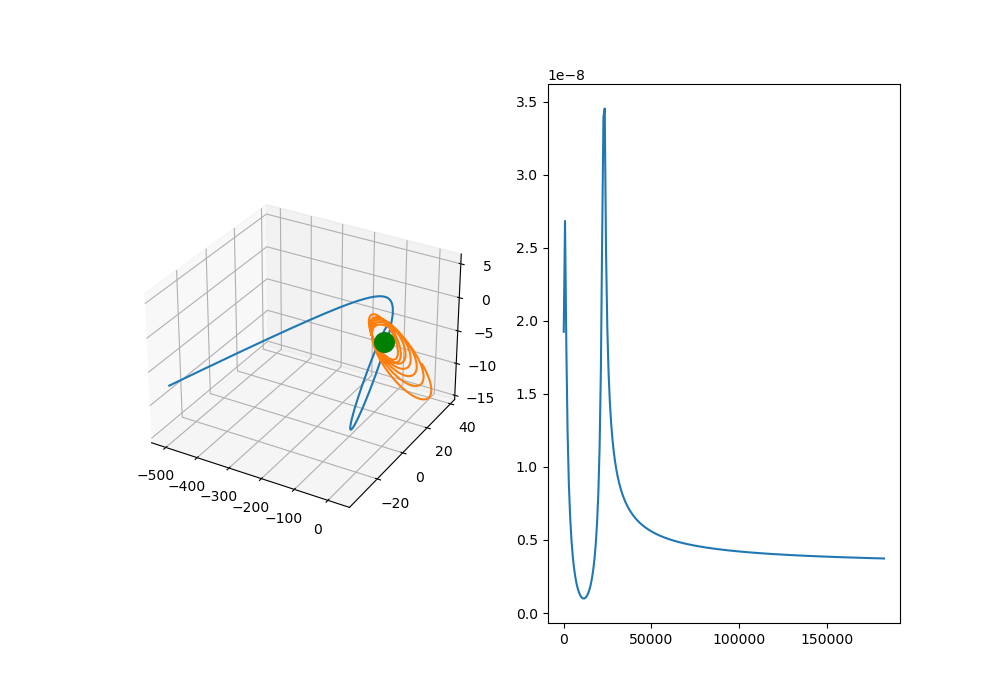

In [143]:
fig= plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.scatter(0,0,0,c='green',s=200)
ax1.plot(solHeun['pos'][3,:],solHeun['pos'][4,:],solHeun['pos'][5,:])
ax1.plot(solHeun['pos'][6,:],solHeun['pos'][7,:],solHeun['pos'][8,:])
ax2 = fig.add_subplot(1,2,2)
ax2.plot(solHeun['t'],solHeun['E'])

plt.show()

### Plot SV

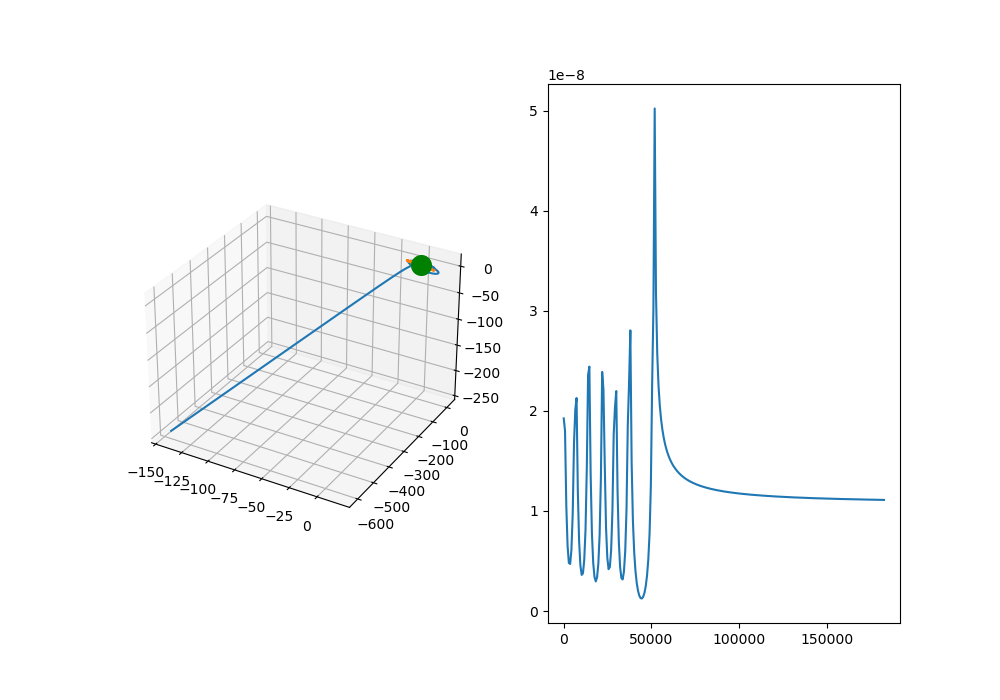

In [144]:
fig= plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.scatter(0,0,0,c='green',s=200)
ax1.plot(solSV['pos'][3,:],solSV['pos'][4,:],solSV['pos'][5,:])
ax1.plot(solSV['pos'][6,:],solSV['pos'][7,:],solSV['pos'][8,:])
ax2 = fig.add_subplot(1,2,2)
ax2.plot(solSV['t'],solSV['E'])

plt.show()